## CS 5010 Final Project
Date: 7 August 2020

Project members: 

Aubrey Brockmiller (alb3cb)

Hemani Choksi (hc8nd)

Bryan DeMarcy (bd2qn)

Mike Wetklow (mw8hu)

### Data Sets

Below are the data sources we used for our project.

Census population data

Source:https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html

List of Us Governors

Source:https://en.m.wikipedia.org/wiki/List_of_United_States_governors

State Abbreviations

Source: https://worldpopulationreview.com/states/state-abbreviations

HHS Spending Data

Source: https://taggs.hhs.gov/coronavirus

COVID-19 Data (**Note:** The COVID-19 data set ranges from the start of the pandemic up to June 30th, 2020)

Source: https://covidtracking.com/data/download

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
from functools import reduce
import plotly.graph_objects as go
import folium
import os
import pygal
from pygal.style import Style

### 1. Data Wrangling

In [2]:
#Read the csv files into pandas
population = pd.read_csv(r'rawData/populationData.csv')
spendingHHS = pd.read_csv(r'rawData/HHSspending.csv')
governors = pd.read_csv (r'rawData/govAffiliation.csv')
abbreviations = pd.read_csv(r'rawData/stateAbbreviations.csv')
covid = pd.read_csv(r'rawData/COVIDdata.csv')

In [3]:
#Reduce the dataframes to only the columns we need for our analysis
population = pd.DataFrame(population, columns= ['NAME', 'POPESTIMATE2019'])
abbreviations = pd.DataFrame(abbreviations, columns = ['State', 'Code'])
covid = pd.DataFrame(covid, columns = ['date', 'state', 'positive', 
                                       'hospitalizedCurrently', 'hospitalizedCumulative', 
                                       'recovered', 'death', 'positiveIncrease', 'totalTestResults'])

In [4]:
#Rename columns to get rid of the multiple variations of the same column and to be more descriptive
population = population.rename(columns={'NAME': 'State', 'POPESTIMATE2019': 'population2019'})
spendingHHS = spendingHHS.rename(columns={'State':'stateCode', 'Award_Amount':'Amount'})
governors = governors.rename(columns={'state': 'stateCode'})
abbreviations = abbreviations.rename(columns={'Code': 'stateCode'})
covid = covid.rename(columns={'state': 'stateCode'})

In [5]:
#Reformat the date column in the covid dataframe and sort by date
covid['date'] = pd.to_datetime(covid['date'].astype(str), format='%Y%m%d')

#Use grouping to find the total HHS spending by state and save it as a dataframe
#The dataframe was given a new name so we could use the spendingHHS dataframe again in Section 4
funding = pd.concat([spendingHHS.groupby(['stateCode'])['Amount'].sum()], axis=1)

In [6]:
#Merge the population and abbreviations dataframes so population contains state names
population = pd.merge(left=abbreviations, right=population, left_on='State', right_on='State')

#Create a list of dataframes to merge
data_frames = [governors, population, funding]

#Merge the list of dataframes
df_merged = reduce(lambda left,right: pd.merge(left,right,on=['stateCode']), data_frames)

#Merge the abbreviations and COVID dataframes so the COVID data contains state names and sort by date
covid = pd.merge(left=abbreviations, right=covid, left_on='stateCode', right_on='stateCode')
covid = covid.sort_values(by=['date'], ascending=True)

In [7]:
#Check dataframes by printing them to csv files
df_merged.to_csv(r'tidyData/df_merged.csv', index=False)
covid.to_csv(r'tidyData/covid.csv', index=False)

### 2. Overall Analysis on the 50 US States

This set of code looks at HHS spending and COVID-19 data for the entire United States.

We learned how to create the choropleth map using https://plotly.com/python/choropleth-maps/.

In [8]:
#lets print the States where they spent more than $150 per person 
df_merged['perCap']=(df_merged['Amount'] / df_merged['population2019']).round(decimals=2)
print(df_merged.loc[df_merged['perCap'] > 150].sort_values(by=['perCap'],ascending=False).to_string(index=False))

stateCode govAffiliation       govName   State  population2019      Amount  perCap
       AK              R Mike Dunleavy  Alaska          731545 296229333.0  404.94
       VT              R    Phil Scott Vermont          623989 102414363.0  164.13
       WY              R   Mark Gordon Wyoming          578759  91129941.0  157.46


In [9]:
#printing states that spent less than $55 per person
print(df_merged.loc[df_merged['perCap'] < 55].sort_values(by=['perCap'],ascending=True).to_string(index=False))

stateCode govAffiliation       govName     State  population2019       Amount  perCap
       FL              R  Ron DeSantis   Florida        21477737 1047299514.0   48.76
       TX              R   Greg Abbott     Texas        28995881 1454565490.0   50.16
       VA              D Ralph Northam  Virginia         8535519  440514013.0   51.61
       OH              R   Mike DeWine      Ohio        11689100  616078949.0   52.71
       MN              D      Tim Walz Minnesota         5639632  304304840.0   53.96


In [10]:
#now lets print states that have the highest amount of recoveries
print(covid.loc[(covid['date'] == '6/30/2020') & (covid['recovered'] > 70000)])

              State stateCode       date  positive  hospitalizedCurrently  \
2464  Massachusetts        MA 2020-06-30  108882.0                  733.0   
5051          Texas        TX 2020-06-30  159986.0                 6533.0   
3752       New York        NY 2020-06-30  393454.0                  891.0   

      hospitalizedCumulative  recovered    death  positiveIncrease  \
2464                 11337.0    93157.0   8054.0               114   
5051                     NaN    84818.0   2424.0              6975   
3752                 89995.0    70487.0  24855.0               524   

      totalTestResults  
2464            848141  
5051           1869282  
3752           3914938  


In [11]:
#print states that currently have less than 100 people hospitalized
covid.loc[(covid['date'] == '6/30/2020') & (covid['hospitalizedCurrently']<100)] \
    .sort_values(by=['hospitalizedCurrently'],ascending=True)

State stateCode       date  positive  hospitalizedCurrently  \
5918        Wyoming        WY 2020-06-30    1487.0                    6.0   
3046        Montana        MT 2020-06-30     967.0                   12.0   
5286        Vermont        VT 2020-06-30    1208.0                   16.0   
116          Alaska        AK 2020-06-30     940.0                   18.0   
3990   North Dakota        ND 2020-06-30    3576.0                   25.0   
5682  West Virginia        WV 2020-06-30    2905.0                   27.0   
2230          Maine        ME 2020-06-30    3253.0                   29.0   
3398  New Hampshire        NH 2020-06-30    5760.0                   34.0   
1411          Idaho        ID 2020-06-30    5752.0                   60.0   
4817   South Dakota        SD 2020-06-30    6764.0                   62.0   
822        Delaware        DE 2020-06-30   11474.0                   64.0   
4576   Rhode Island        RI 2020-06-30   16911.0                   74.0   
706     Connecticut        CT 2020-06-30   46514.0                   98.0   

      hospitalizedCumulative  recovered   death  positiveIncrease  \
5918                   117.0     1097.0    20.0                37   
3046                   101.0      642.0    22.0                48   
5286                     NaN      953.0    56.0                 0   
116                      NaN      526.0    14.0                36   
3990                   231.0     3195.0    78.0                37   
5682                     NaN     2272.0    93.0                35   
2230                   348.0     2646.0   105.0                34   
3398                   565.0     4435.0   367.0                 0   
1411                   322.0     4073.0    91.0               433   
4817                   666.0     5872.0    91.0                48   
822                      NaN     6667.0   509.0                98   
4576                  2001.0     1631.0   950.0                40   
706                  10268.0     8053.0  4322.0               152   

      totalTestResults  
5918             33672  
3046             90861  
5286             65764  
116             112185  
3990            106122  
5682            171764  
2230             94952  
3398            118298  
1411             89303  
4817             80088  
822             110881  
4576            154083  
706             478358

In [12]:
#print states that haven't had any new positive cases in the past week
covid.loc[(covid['date'] > '6/23/2020') & (covid['date'] <= '6/30/2020') \
    & (covid['positiveIncrease'] == 0)]

State stateCode       date  positive  hospitalizedCurrently  \
1885         Kansas        KS 2020-06-25   12970.0                    NaN   
356        Arkansas        AR 2020-06-26   18062.0                  284.0   
2117      Louisiana        LA 2020-06-27   54769.0                  700.0   
4462   Pennsylvania        PA 2020-06-27   84370.0                  651.0   
2000       Kentucky        KY 2020-06-27   14859.0                  387.0   
1883         Kansas        KS 2020-06-27   13538.0                    NaN   
3401  New Hampshire        NH 2020-06-27    5671.0                   32.0   
1882         Kansas        KS 2020-06-28   13538.0                    NaN   
4935      Tennessee        TN 2020-06-28   40172.0                  800.0   
1412          Idaho        ID 2020-06-29    5319.0                   50.0   
1880         Kansas        KS 2020-06-30   14443.0                    NaN   
5286        Vermont        VT 2020-06-30    1208.0                   16.0   
3398  New Hampshire        NH 2020-06-30    5760.0                   34.0   

      hospitalizedCumulative  recovered   death  positiveIncrease  \
1885                  1082.0      747.0   261.0                 0   
356                   1300.0    12127.0   240.0                 0   
2117                     NaN    39792.0  3190.0                 0   
4462                     NaN    65808.0  6579.0                 0   
2000                  2589.0     3730.0   553.0                 0   
1883                  1128.0      779.0   264.0                 0   
3401                   561.0     4381.0   365.0                 0   
1882                  1128.0      779.0   264.0                 0   
4935                  2564.0    26159.0   584.0                 0   
1412                   312.0     3898.0    91.0                 0   
1880                  1152.0      794.0   270.0                 0   
5286                     NaN      953.0    56.0                 0   
3398                   565.0     4435.0   367.0                 0   

      totalTestResults  
1885            161705  
356             277380  
2117            678006  
4462            719081  
2000            350754  
1883            167859  
3401            114768  
1882            167859  
4935            748553  
1412             86345  
1880            176725  
5286             65764  
3398            118298

In [13]:
#Choropleth map of the US based on HHS spending

#Create a copy of our df_merged dataframe so we can convert everything in the copy to a string
df_mergedCopy = df_merged.copy()

#Convert columns to strings
for col in df_mergedCopy.columns:
    df_mergedCopy[col] = df_mergedCopy[col].astype(str)

#Text that will be displayed when hovering over each state
df_mergedCopy['text'] = df_mergedCopy['stateCode'] + '<br>' + \
    'Governor Affiliation: ' + df_mergedCopy['govAffiliation']  + '<br>' + \
    'Governor: ' + df_mergedCopy['govName'] + '<br>' + \
    'Population: ' + df_mergedCopy['population2019'] + '<br>' + \
    'Money per Person: $ ' + df_mergedCopy['perCap']

fig = go.Figure(data=go.Choropleth(
    locations=df_mergedCopy['stateCode'], # Spatial coordinates
    z = df_mergedCopy['Amount'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    text=df_mergedCopy['text'], # hover text
    colorscale = 'Greens',
    colorbar_title = "Millions USD",
))

fig.update_layout(
    title_text = 'COVID-19 HHS Spending',
    geo_scope='usa', # limit map scope to USA
)

fig.show()

### 3. User Input Query and Analysis

This next section allows the user to input a list of states for comparative analysis. Only states from the user input will be shown so HHS spending and COVID-19 data can be compared between states.

**Note:** The layout and figure sizes were set to only compare a handful of states at once. The user can input "all" to compare all 50 states simultaneously; however, the visuals will be very crowded and difficult to read.

In [14]:
#Set the index in the df_merged dataframe for lookup purposes
df_merged = df_merged.set_index('stateCode')

In [15]:
#This class will be used for data visualizations and user input
class Data:
    
    def __init__(self, states=None): #Constructor
        self.df = pd.DataFrame() #Create an empty dataframe for each instance
        if states is None: 
            #Ask user for a list of state abbreviations or 'all' to represent all 50 states
            self.states = input("Enter a list of state abbreviations separated by a space or type 'all' without quotes to compare all 50 states: ")
        elif states == False: #This if statement allows us to create an empty dataframe later without being prompted for input
            self.states = [] 
        else: #This allows the user to input states as a list when creating the instance; however, we won't use it this way
            self.states = states
        
    def userStates(self): #Method for user input
        #Make the userList global so we can call it later
        global userList
        
        #If the user inputs "all", the list will include all state abbreviations
        if self.states == "all":
            userList = df_merged.index.values.tolist()
            print("Thank you for your input. We will show you the data for all 50 states!")
        
        #If the user does not input "all", split the input by space
        else:
            userList = self.states.split()
            try:
                test = userList[0] #Test to see if the list is empty
                for state in userList:
                    testList = []
                    testList.append(df_merged.loc[state].values[0:(len(df_merged.columns)+1)]) #Search the df_merged dataframe and append every row based on the state in the user list
                print("Thank you for your input. We will show you the data for the states listed below. \n", userList)        
            
            except IndexError: #Prints an error if the user enters an empty list
                return print("ERROR: You did not enter a state abbreviation. Please rerun the code using at least one of the state abbreviations below. \n", df_merged[["State"]],"\n")
                
            except KeyError: #Prints an error if the user does not enter a valid state abbreviation
                return print("ERROR: ",str(state)," is not one of the state abbreviations. Please rerun the code using any combination of the state abbreviations below. \n", df_merged[["State"]],"\n")
                        
    #This method is used to create our line, bar, and pie charts
    #Required arguments are ones that appear in all plot types, otherwise they are optional.
    def userPlot(self, plotType, title, y, ylabel, legendIndex, x=None, xlabel=None, 
                 axis=None, legendlabel=None, size=None, rotation=None):
        
        if plotType == "line": #Create a line plot using the specified dataframe
            self.df.plot(kind=plotType, x=x, y=y, ax=axes[axis], legend=legendIndex, 
                         label=self.df.iloc[0][legendlabel])
            axes[axis].xaxis.set_label_text(xlabel)
            axes[axis].yaxis.set_label_text(ylabel)
            axes[axis].set_title(title)
        
        elif plotType == "bar": #Create a bar plot using the specified dataframe
            self.df.plot.bar(x, y, rot=rotation, legend=legendIndex, figsize=(size))
            plot.xlabel(xlabel)
            plot.ylabel(ylabel)
            plot.title(title)
        
        elif plotType == "pie": #Create a pie chart using the specified dataframe
            self.df.plot.pie(y=y, ax=axes[axis], labels=self.df[legendlabel], 
                             legend=legendIndex, autopct='%1.1f%%')
            axes[axis].yaxis.set_label_text(ylabel)
            axes[axis].set_title(title)      
    
    #This method is used to create stacked bar plots
    def stackedPlot(self, columns, rowAxis, colAxis, xlabel=None, ylabel=None, title=None, rotation=None):
        self.df[columns].plot(kind="bar", stacked=True, ax=axes[rowAxis,colAxis], rot=rotation)
        axes[rowAxis,colAxis].xaxis.set_label_text(xlabel)
        axes[rowAxis,colAxis].yaxis.set_label_text(ylabel)
        axes[rowAxis,colAxis].set_title(title)

In [16]:
#Create an instance
user1 = Data()

#Run the userStates() method to make sure the user inputs a valid list
user1.userStates()

Enter a list of state abbreviations separated by a space or type 'all' without quotes to compare all 50 states: SC PA VA
Thank you for your input. We will show you the data for the states listed below. 
 ['SC', 'PA', 'VA']


Below is each state's political affiliation based on your input. 

         State govAffiliation        govName
  Pennsylvania              D       Tom Wolf
South Carolina              R Henry McMaster
      Virginia              D  Ralph Northam


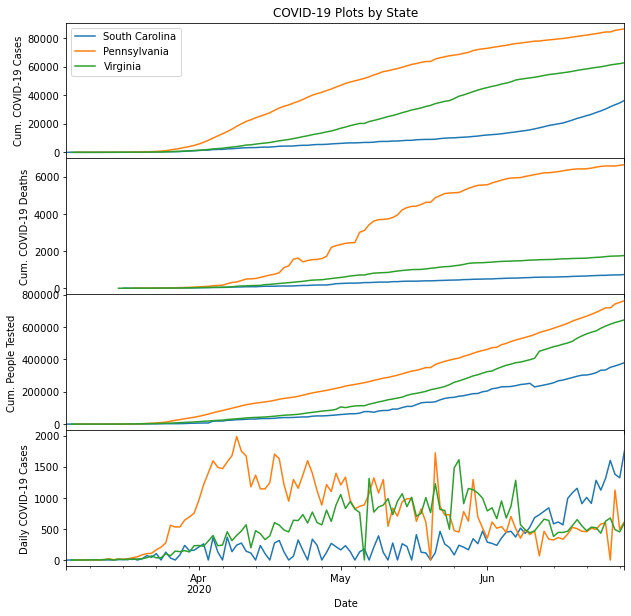

In [17]:
#Create an empty list to append df_merged information we want to plot later
dummyList = []

#Create empty dataframes to append data from df_merged and COVID, respectively, based on user input
userMerged = Data(False) #Create an instance to pass through plotting methods later
userCOVID = Data(False)
i = Data(False) #Create an instance to pass through the userPlot() method

#Create the figure and set the axes for plotting the COVID data
fig, axes = plot.subplots(4, sharex=True, sharey=False, gridspec_kw={'hspace': 0}, figsize=(10,10))

#Iterate over every state from the user input
for state in userList:
    #Append a nested list of every state's information based on the user input
    dummyList.append(df_merged.loc[state].values[0:(len(df_merged.columns)+1)])
    #Creates a dummy dataframe based on each state
    i.df = covid.loc[covid['stateCode'] == state]
    #Plot the desired data with the userPlot method
    i.userPlot('line', "COVID-19 Plots by State", 'positive', "Cum. COVID-19 Cases", 
               True, x='date', xlabel="", axis=0, legendlabel='State')
    i.userPlot('line', "", 'death',"Cum. COVID-19 Deaths", False, x='date', 
               xlabel="", axis=1, legendlabel='State')
    i.userPlot('line', "", 'totalTestResults',"Cum. People Tested", False, x='date', 
               xlabel="", axis=2, legendlabel='State')
    i.userPlot('line', "", 'positiveIncrease',"Daily COVID-19 Cases", False, x='date', 
               xlabel="Date", axis=3, legendlabel='State')
    #Append the dummy dataframe to our userCOVID dataframe for every iteration of state
    userCOVID.df = userCOVID.df.append(i.df)

#Update the userMerged dataframe based on the dummyList of state's information
userMerged.df = pd.DataFrame(dummyList, columns = df_merged.columns).sort_values(by=['State'], ascending=True)

#Print results
print('Below is each state\'s political affiliation based on your input. \n')
print(userMerged.df[['State', 'govAffiliation', 'govName']].to_string(index=False))

In [18]:
#Data wrangling on user input

#Overwrite the userCOVID dataframe to include only the max death, number of tests, and positive case values. 
#The values are cumulative so the max will correspond to the most recent date
userCOVID.df = pd.concat([userCOVID.df.groupby(['State'])['death'].max(), 
                          userCOVID.df.groupby(['State'])['positive'].max(),
                          userCOVID.df.groupby(['State'])['totalTestResults'].max()], 
                         axis=1)

#Calculate death percentage in people testing positive for COVID-19
userCOVID.df['deathPct'] = userCOVID.df['death'] / userCOVID.df['positive'] *100

#Calculate positive test percentage in people getting tested
userCOVID.df['posPct'] = userCOVID.df['positive'] / userCOVID.df['totalTestResults'] *100

                death positive totalTestResults deathPct  posPct
State                                                           
Pennsylvania    6,649   86,606          764,187    7.68%  11.33%
South Carolina    739   36,399          380,572    2.03%   9.56%
Virginia        1,763   62,787          645,034    2.81%   9.73%




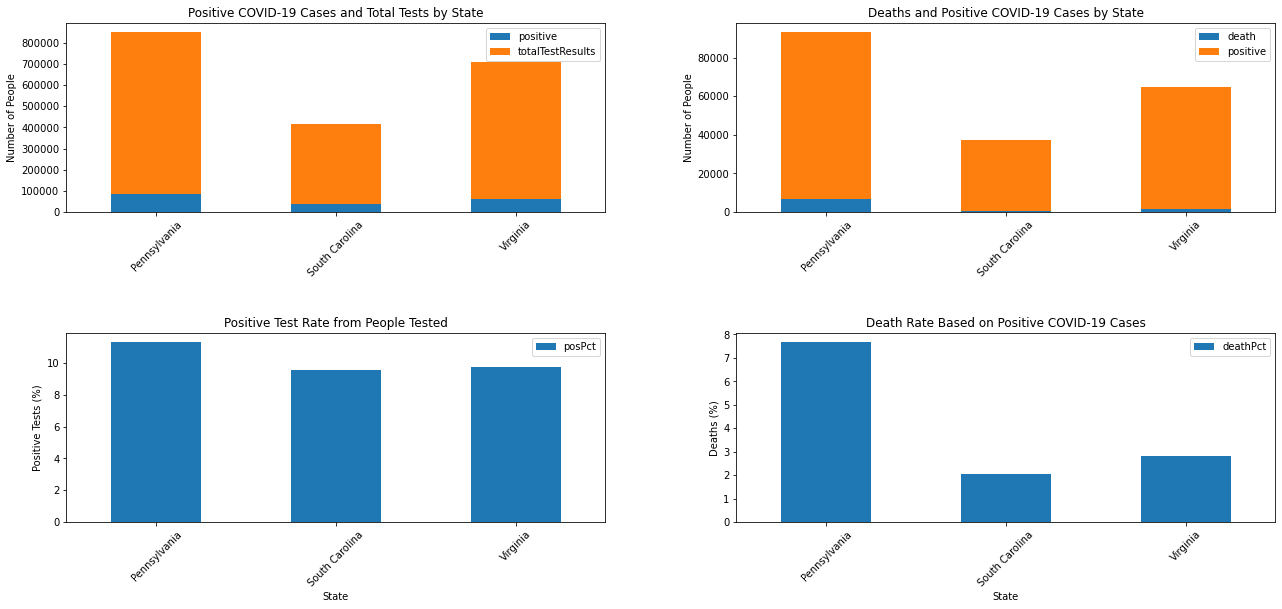

In [19]:
#Plot total COVID-19 metrics for the user input states

#Set figure and build subplots
fig, axes = plot.subplots(2, 2, figsize=(20,10))
fig.tight_layout(pad=10.0)

#Plot COVID-19 totals for the user input states using the stackedPlot method
userCOVID.stackedPlot(["positive","totalTestResults"],0,0, xlabel="", ylabel="Number of People", 
                      title="Positive COVID-19 Cases and Total Tests by State", rotation=45)
userCOVID.stackedPlot(["posPct"], 1, 0, xlabel="State", ylabel="Positive Tests (%)", 
                      title="Positive Test Rate from People Tested", rotation=45)
userCOVID.stackedPlot(["death", "positive"], 0, 1, xlabel="", ylabel="Number of People", 
                      title="Deaths and Positive COVID-19 Cases by State", rotation=45)
userCOVID.stackedPlot(["deathPct"], 1, 1, xlabel="State", ylabel="Deaths (%)", 
                      title="Death Rate Based on Positive COVID-19 Cases", rotation=45)

#Reformat the dataframe column values to look nicer when printed
format_dict = {'death':'{:,.0f}', 'positive':'{:,.0f}', 'totalTestResults':'{:,.0f}', 
               'deathPct':'{:.2f}%', 'posPct':'{:.2f}%'}
for key, value in format_dict.items():
    userCOVID.df[key] = userCOVID.df[key].apply(value.format)
    
#Print the table of data that are being plotted
print(userCOVID.df)
print("\n")

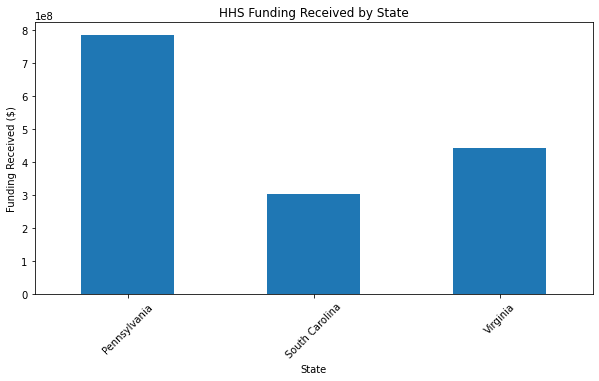

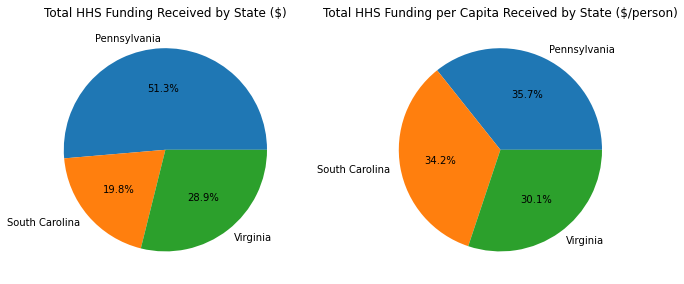

In [20]:
#Plot HHS spending metrics for the user input states

#Create a bar plot for HHS funding by state
userMerged.userPlot("bar", "HHS Funding Received by State", 'Amount', 
                    "Funding Received ($)", False, x='State', xlabel="State", 
                    rotation=45, size=(10,5))

#Set figure and build subplots
fig, axes = plot.subplots(1,2, figsize=(10,10))
fig.tight_layout(pad=5.0)

#Create pie charts for HHS funding by state and fundering per capita by state
userMerged.userPlot("pie", "Total HHS Funding Received by State ($)", 'Amount', "", 
                    False, axis=0, legendlabel='State')
userMerged.userPlot("pie", "Total HHS Funding per Capita Received by State ($/person)", 
                    'perCap', "", False, axis=1, legendlabel='State')

In [21]:
#Reformat the dataframe column values to look nicer when printed
userMerged.df['population2019'] = userMerged.df['population2019'].map('{:,.0f}'.format)
userMerged.df['Amount'] = userMerged.df['Amount'].map('${:,.0f}'.format)
userMerged.df['perCap'] = userMerged.df['perCap'].map('${:,.2f}'.format)

In [22]:
#Print the table that is associated with the figures plotted above
print(userMerged.df[["govAffiliation", "govName", "State", "population2019", 
                     "Amount", "perCap"]].to_string(index=False))

govAffiliation        govName          State population2019       Amount perCap
             D       Tom Wolf   Pennsylvania     12,801,989 $783,022,769 $61.16
             R Henry McMaster South Carolina      5,148,714 $301,397,872 $58.54
             D  Ralph Northam       Virginia      8,535,519 $440,514,013 $51.61


### 4. Breakdown of HHS Spending

Data Decription:  The data in this section lists awards made by HHS (from February 2020 to June 2020) using emergency supplemental appropriation funding provided in the Coronavirus Preparedness and Response Supplemental Appropriations Act, 2020,the Families First Coronavirus Response Act, the CARES Act (Coronavirus Aid, Relief, and Economic Security Act), and the Paycheck Protection Program and Health Care Enhancement Act. 

Data Variables:

Number = The Catalog of Federal Domestic Assistance (CFDA) Number

Title = The title of the HHS Government Program

Name = The recipient of the government funds who provides COVID19 related Services

State = The State or U.S. Territory that received HHS COVID19 funding

Amount = The Award Amount in dollars

The treemaps were created by watching a tutorial from https://www.youtube.com/watch?v=eiq__4mg00o and reading about them on https://plotly.com/python/treemaps/.

In [23]:
#Merge the spendingHHS and abbreviations dataframes so we eliminate data from US territories
spendingHHS = pd.merge(left=abbreviations, right=spendingHHS, left_on='stateCode', right_on='stateCode')

In [24]:
#Query 1:  What is the total amount of HHS health spending through June 30, 2020?
print('${:,.0f}'.format(spendingHHS.Amount.sum()))

$22,976,951,725


In [25]:
#Query 2:  What is the total amount of health spending by state through June 30, 2020?
spendingHHS.groupby('State').Amount.sum().map('${:,.0f}'.format)

State
Alabama                   $297,054,496
Alaska                    $296,229,333
Arizona                   $488,730,674
Arkansas                  $203,988,670
California              $2,301,535,272
Colorado                  $340,596,404
Connecticut               $324,650,326
Delaware                  $107,967,343
District of Columbia      $201,023,752
Florida                 $1,047,299,514
Georgia                   $775,529,463
Hawaii                    $108,535,217
Idaho                     $135,532,559
Illinois                  $947,925,479
Indiana                   $415,191,818
Iowa                      $219,744,959
Kansas                    $196,765,821
Kentucky                  $285,631,510
Louisiana                 $400,872,226
Maine                     $124,972,727
Maryland                  $407,991,520
Massachusetts             $667,949,578
Michigan                  $704,026,410
Minnesota                 $304,304,840
Mississippi               $240,952,468
Missouri           

In [26]:
#Query 3:  What is the total amount of health spending by a given state?
print('${:,.0f}'.format(spendingHHS.loc[spendingHHS['stateCode'] == 'VA'].Amount.sum()))

$440,514,013


In [27]:
#Show the full dataframe
pd.set_option("display.max_rows", None, "display.max_columns", None)

#Query 4: For each State and Program Title, what is the total amount of VA, NY, VT, TX, and CA spending?
df = (spendingHHS.loc[(spendingHHS['stateCode'] == 'VA') | (spendingHHS['stateCode'] == 'NY') | 
                                (spendingHHS['stateCode'] == 'VT') | (spendingHHS['stateCode'] == 'TX') | 
                                (spendingHHS['stateCode'] == 'CA')]
                 .groupby(['stateCode', 'Title'])
                 .Amount.sum()
                 .map('${:,.0f}'.format)
                 .to_frame()
                 .sort_values(by=['stateCode','Amount'], ascending=[True, False]))

df

Amount
stateCode Title                                                             
CA        Area Health Education Centers                              $95,455
          ACL Centers for Independent Living                      $9,086,298
          Community Services Block Grant                         $89,150,063
          Public Health Emergency Response:  Cooperative ...     $86,100,242
          Epidemiology and Laboratory Capacity for Infect...    $857,891,761
          Family Violence Prevention and Services/State D...         $80,357
          Section 223 Demonstration Programs to Improve C...      $8,000,000
          Nurse Education, Practice Quality and Retention...         $78,571
          Special Programs for the Aging, Title III, Part...     $75,259,143
          Hospital Preparedness Program (HPP) Ebola Prepa...        $650,000
          Indian Self-Determination                                 $646,624
          Protecting and Improving Health Globally: Build...        $630,500
          Injury Prevention and Control Research and Stat...        $620,563
          Centers of Excellence                                     $600,000
          HIV-Related Training and Technical Assistance             $600,000
          Grants for New and Expanded Services under the ...      $6,085,074
          Poison Center Support and Enhancement Grant               $571,712
          Sexually Transmitted Diseases (STD) Provider Ed...      $5,330,300
          Emerging Infections Sentinel Networks                   $5,297,784
          Low-Income Home Energy Assistance                      $49,710,971
          Head Start                                             $44,255,352
          Coordinated Services and Access to Research for...        $415,809
          Stephanie Tubbs Jones Child Welfare Services Pr...      $4,586,592
          Strengthening Public Health Systems and Service...      $4,550,000
          Family Violence Prevention and Services/Domesti...      $4,478,931
          Emergency Grants to Address Mental and Substanc...      $4,455,344
          Small Rural Hospital Improvement Grant Program          $4,215,850
          PPHF Geriatric Education Centers                          $362,500
          Child Care and Development Block Grant                $352,759,195
          Health Center Program (Community Health Centers...    $304,196,489
          Tribal Self-Governance Program: IHS Compacts/Fu...     $30,843,253
          Grants to Provide Outpatient Early Intervention...      $3,339,276
          Special Programs for the Aging, Title VI, Part ...      $3,136,340
          HIV Emergency Relief Project Grants                     $3,133,087
          Tribal Public Health Capacity Building and Qual...      $3,005,629
          Special Programs for the Aging, Title IV, and T...      $3,005,454
          National Bioterrorism Hospital Preparedness Pro...     $26,807,003
          Education and Prevention Grants to Reduce Sexua...        $245,999
          Allergy and Infectious Diseases Research              $222,468,020
          Special Programs for the Aging, Title III, Part...     $20,905,320
          Immunization Cooperative Agreements                    $20,074,619
          Emerging Infections Programs                            $2,600,000
          Rural Health Care Services Outreach, Rural Heal...      $2,289,074
          Special Programs for the Aging, Title VII, Chap...      $2,090,531
          Activities to Support State, Tribal, Local and ...     $16,884,208
          National Family Caregiver Support, Title III, P...     $10,331,215
          Substance Abuse and Mental Health Services Proj...      $1,948,040
          Telehealth Programs                                     $1,657,142
          HIV Care Formula Grants                                 $1,500,000
          Transitional Living for Homeless Youth                  $1,195,202
          Basic Center Grant                                      

### 5. Treemap Visuals of HHS Spending

Resource/Source: Ryan Noonan, Python Treemaps, https://www.youtube.com/watch?v=eiq__4mg00o&t=393s

Spending Treemap charts were developed to representing data in the form of rectangles. The area or size of each rectangle corresponds to its numerical value.

In [28]:
#Sort Program by Total Amount
Total_Amount_by_Program = (spendingHHS.groupby('Title')['Amount']
                      .sum()
                      .sort_values(ascending=False)
                      .reset_index(name='Amount'))

# Create a dataframe to include only award amounts greater than 100000000
Total_Amount_by_Program = Total_Amount_by_Program[Total_Amount_by_Program['Amount'] > 100000000]

In [29]:
#Create a list of unique programs
Program = Total_Amount_by_Program.Title.unique()

ModuleNotFoundError: No module named 'cairosvg'

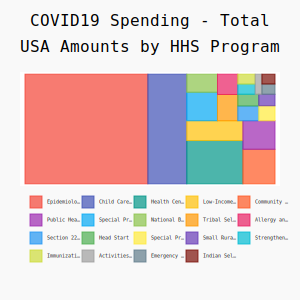

In [30]:
#Create Treemap settings, colors correspond to Program
custom_style = Style(legend_font_size=5)

Program_treemap = pygal.Treemap(width=300, height=300, style=custom_style, legend_at_bottom=True)
Program_treemap.title = 'COVID19 Spending - Total USA Amounts by HHS Program'

# Create a for loop for each of the Program types matching Program in the Program list variable, show total Amount
for i in Program:
    Program_treemap.add(i, Total_Amount_by_Program[Total_Amount_by_Program.Title == i]['Amount'])
#Display Treemap
Program_treemap

In [31]:
#This is the same dattaframe as df a few cells above but without the Amount column formatted as currency and the index reset
stateSpending = (spendingHHS.loc[(spendingHHS['stateCode'] == 'VA') | (spendingHHS['stateCode'] == 'NY') | 
                                (spendingHHS['stateCode'] == 'VT') | (spendingHHS['stateCode'] == 'TX') | 
                                (spendingHHS['stateCode'] == 'CA')]
                 .groupby(['stateCode', 'Title'])
                 .Amount.sum()
                 .to_frame()
                 .sort_values(by=['stateCode','Amount'], ascending=[True, False])
                 .reset_index())

In [32]:
# Create a dataframe to include only award amounts greater than 10000000
stateSpending = stateSpending[stateSpending['Amount'] > 10000000]

ModuleNotFoundError: No module named 'cairosvg'

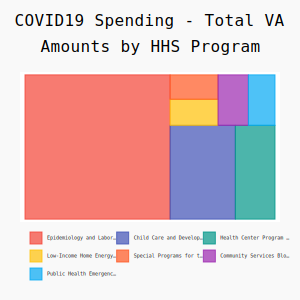

In [33]:
#Create treemap for VA spending
VA_Program = stateSpending.loc[stateSpending['stateCode'] == 'VA'].Title.unique()

custom_style = Style(legend_font_size=5)
VA_Program_treemap = pygal.Treemap(width=300, height=300, style=custom_style, legend_at_bottom=True)
VA_Program_treemap.title = 'COVID19 Spending - Total VA Amounts by HHS Program'

for j in VA_Program:
    VA_Program_treemap.add(j, stateSpending[stateSpending.Title == j]['Amount'].sum()) 

VA_Program_treemap

ModuleNotFoundError: No module named 'cairosvg'

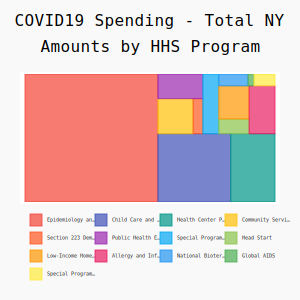

In [34]:
#Create treemap for NY
NY_Program = stateSpending.loc[stateSpending['stateCode'] == 'NY'].Title

custom_style = Style(legend_font_size=5)
NY_Program_treemap = pygal.Treemap(width=300, height=300, style=custom_style, legend_at_bottom=True)
NY_Program_treemap.title = 'COVID19 Spending - Total NY Amounts by HHS Program'

for j in NY_Program:
    NY_Program_treemap.add(j, stateSpending[stateSpending.Title == j]['Amount'].sum()) 
    
NY_Program_treemap

ModuleNotFoundError: No module named 'cairosvg'

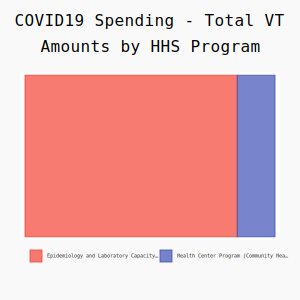

In [35]:
#Create treemap for VT
VT_Program = stateSpending.loc[stateSpending['stateCode'] == 'VT'].Title

custom_style = Style(legend_font_size=5)
VT_Program_treemap = pygal.Treemap(width=300, height=300, style=custom_style, legend_at_bottom=True)
VT_Program_treemap.title = 'COVID19 Spending - Total VT Amounts by HHS Program'

for j in VT_Program:
    VT_Program_treemap.add(j, stateSpending[stateSpending.Title == j]['Amount'].sum()) 
    
VT_Program_treemap

ModuleNotFoundError: No module named 'cairosvg'

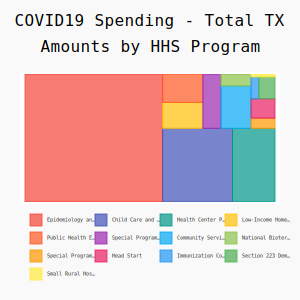

In [36]:
#Create treemap for TX
TX_Program = stateSpending.loc[stateSpending['stateCode'] == 'TX'].Title

custom_style = Style(legend_font_size=5)
TX_Program_treemap = pygal.Treemap(width=300, height=300, style=custom_style, legend_at_bottom=True)
TX_Program_treemap.title = 'COVID19 Spending - Total TX Amounts by HHS Program'

for j in TX_Program:
    TX_Program_treemap.add(j, stateSpending[stateSpending.Title == j]['Amount'].sum()) 
    
TX_Program_treemap

ModuleNotFoundError: No module named 'cairosvg'

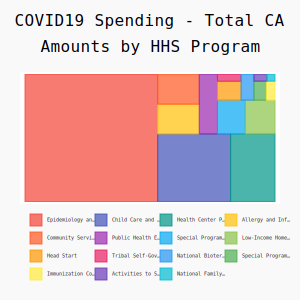

In [37]:
#Create treemap for CA
CA_Program = stateSpending.loc[stateSpending['stateCode'] == 'CA'].Title

custom_style = Style(legend_font_size=5)
CA_Program_treemap = pygal.Treemap(width=300, height=300, style=custom_style, legend_at_bottom=True)
CA_Program_treemap.title = 'COVID19 Spending - Total CA Amounts by HHS Program'

for j in CA_Program:
    CA_Program_treemap.add(j, stateSpending[stateSpending.Title == j]['Amount'].sum()) 
    
CA_Program_treemap